# Exploratory data analysis

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os
import sys
import tqdm
import warnings
import logging
import random
from pathlib import Path
import numpy as np
from collections import defaultdict

warnings.filterwarnings("ignore")
sys.path.append(str(Path(os.getcwd() + '/../../').resolve()))
np.warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.misc import imread
from IPython.core.display import Image, display
import tensorflow as tf

from hupaic.data import Dataset
from hupaic import main

## Get a feel of the dataset

In [3]:
logger = main.getLogger()
input_dir = (Path(os.getcwd()) / ".." / ".." / "input" / "human-protein-atlas-image-classification").resolve()
train_input_dir = input_dir / "train"
test_input_dir = input_dir / "test"

#ds = Dataset(logger, train_input_dir)
train_df = pd.read_csv(input_dir / "train.csv")
sample_df = pd.read_csv(input_dir / "sample_submission.csv")

## Look at training set

In [4]:
train_df.head()

Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18

## Number of samples

In [5]:
len(train_df)

31072

In [6]:
labels_dict = {0: "0. Nucleoplasm",
1: "1.  Nuclear membrane",
2: "2.  Nucleoli",   
3: "3.  Nucleoli fibrillar center",
4: "4.  Nuclear speckles",
5: "5.  Nuclear bodies",
6: "6.  Endoplasmic reticulum",  
7: "7.  Golgi apparatus",
8: "8.  Peroxisomes", 
9: "9.  Endosomes",
10: "10.  Lysosomes",
11: "11.  Intermediate filaments",
12: "12.  Actin filaments",
13: "13.  Focal adhesion sites",
14: "14.  Microtubules",
15: "15.  Microtubule ends",
16: "16.  Cytokinetic bridge",
17: "17.  Mitotic spindle",
18: "18.  Microtubule organizing center",
19: "19.  Centrosome",
20: "20.  Lipid droplets",
21: "21.  Plasma membrane",
22: "22.  Cell junctions",
23: "23.  Mitochondria",
24: "24.  Aggresome",
25: "25.  Cytosol",
26: "26.  Cytoplasmic bodies",
27: "27.  Rods & rings"}

target_count = defaultdict(int)

for id, row in train_df.iterrows():
    labels_indexes = [int(label) for label in row["Target"].split()]
    for label in labels_indexes:
        target_count[labels_dict[label]] += 1
        
target_count = sorted(target_count.items(), key=lambda v: v[1], reverse=True)
print(f"Number of targets: ")
for target, count in target_count:
    print(f"{target:40}: {count}")

Number of targets: 
0. Nucleoplasm                          : 12885
25.  Cytosol                            : 8228
21.  Plasma membrane                    : 3777
2.  Nucleoli                            : 3621
23.  Mitochondria                       : 2965
7.  Golgi apparatus                     : 2822
5.  Nuclear bodies                      : 2513
4.  Nuclear speckles                    : 1858
3.  Nucleoli fibrillar center           : 1561
19.  Centrosome                         : 1482
1.  Nuclear membrane                    : 1254
11.  Intermediate filaments             : 1093
14.  Microtubules                       : 1066
6.  Endoplasmic reticulum               : 1008
18.  Microtubule organizing center      : 902
22.  Cell junctions                     : 802
12.  Actin filaments                    : 688
13.  Focal adhesion sites               : 537
16.  Cytokinetic bridge                 : 530
26.  Cytoplasmic bodies                 : 328
24.  Aggresome                          : 322

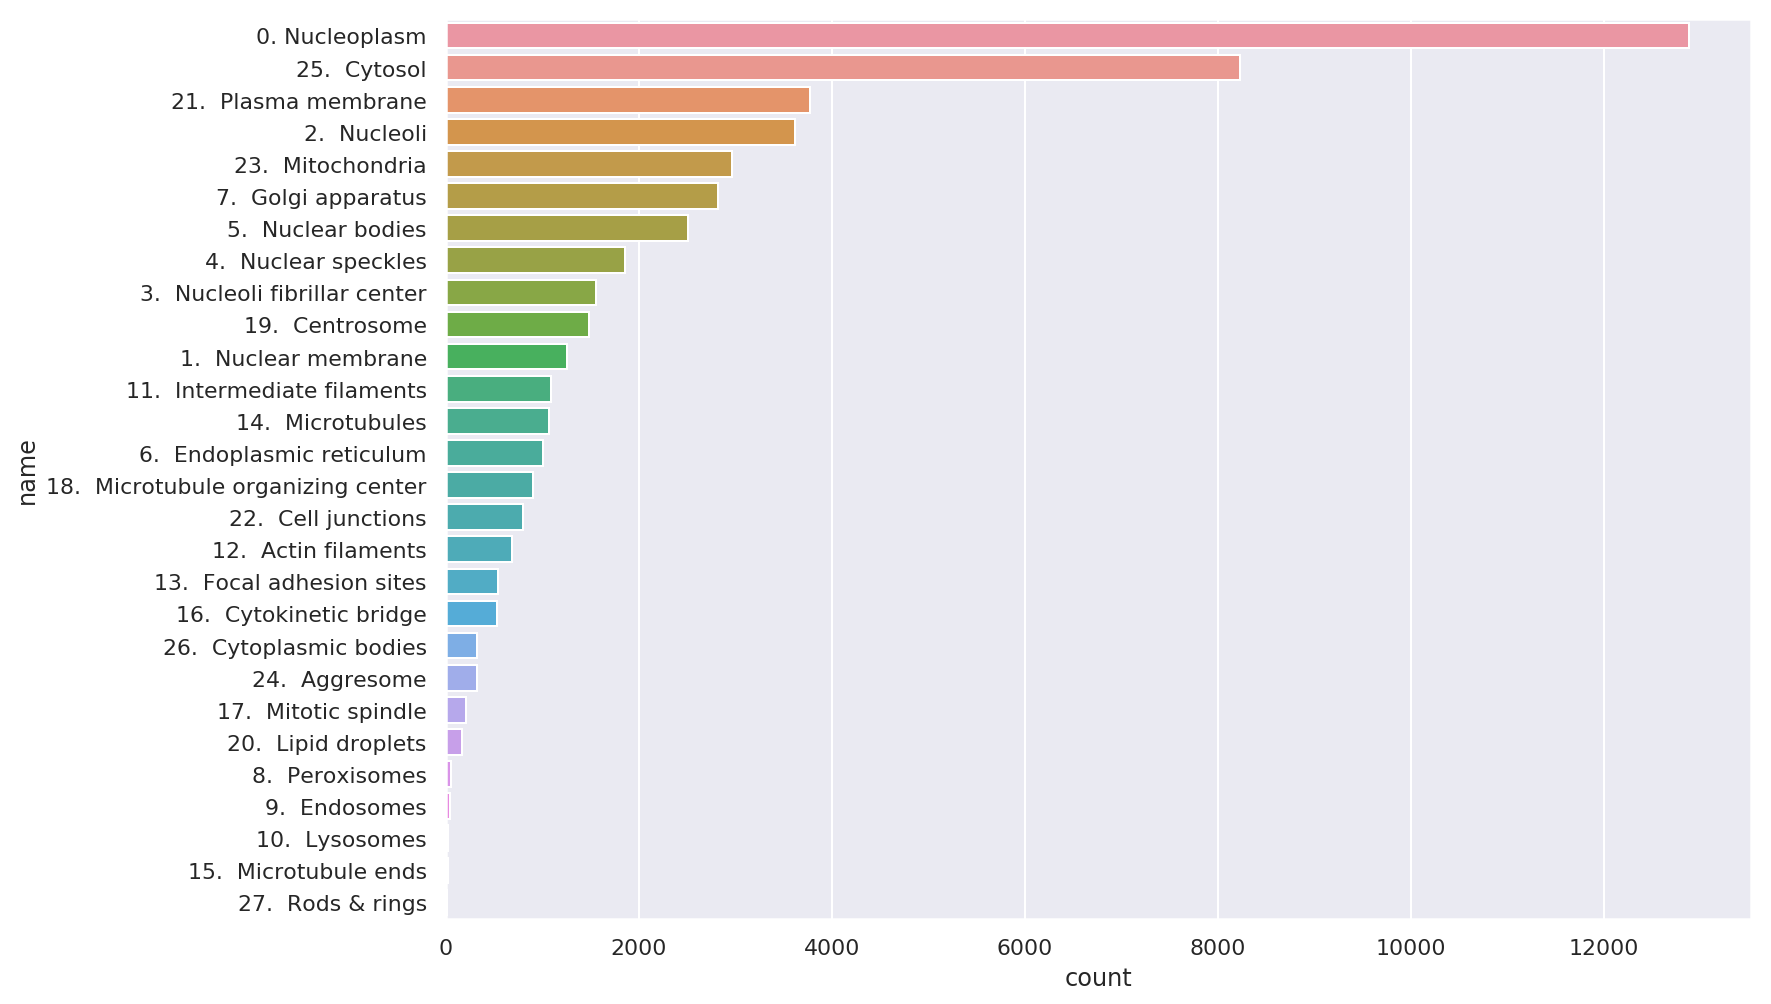

In [7]:
tcount_df = pd.DataFrame(target_count, columns=["name", "count"])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x="count", y="name", data=tcount_df);

## Look at sample submission

In [8]:
sample_df.head()

Id  Predicted
0  00008af0-bad0-11e8-b2b8-ac1f6b6435d0          0
1  0000a892-bacf-11e8-b2b8-ac1f6b6435d0          0
2  0006faa6-bac7-11e8-b2b7-ac1f6b6435d0          0
3  0008baca-bad7-11e8-b2b9-ac1f6b6435d0          0
4  000cce7e-bad4-11e8-b2b8-ac1f6b6435d0          0

## Look at the images

 - a **green filter** for the target protein structure of interest
 - **blue landmark filter** for the nucleus
 - **red landmark filter** for microtubules
 - **yellow landmark filter** for the endoplasmatic reticulum

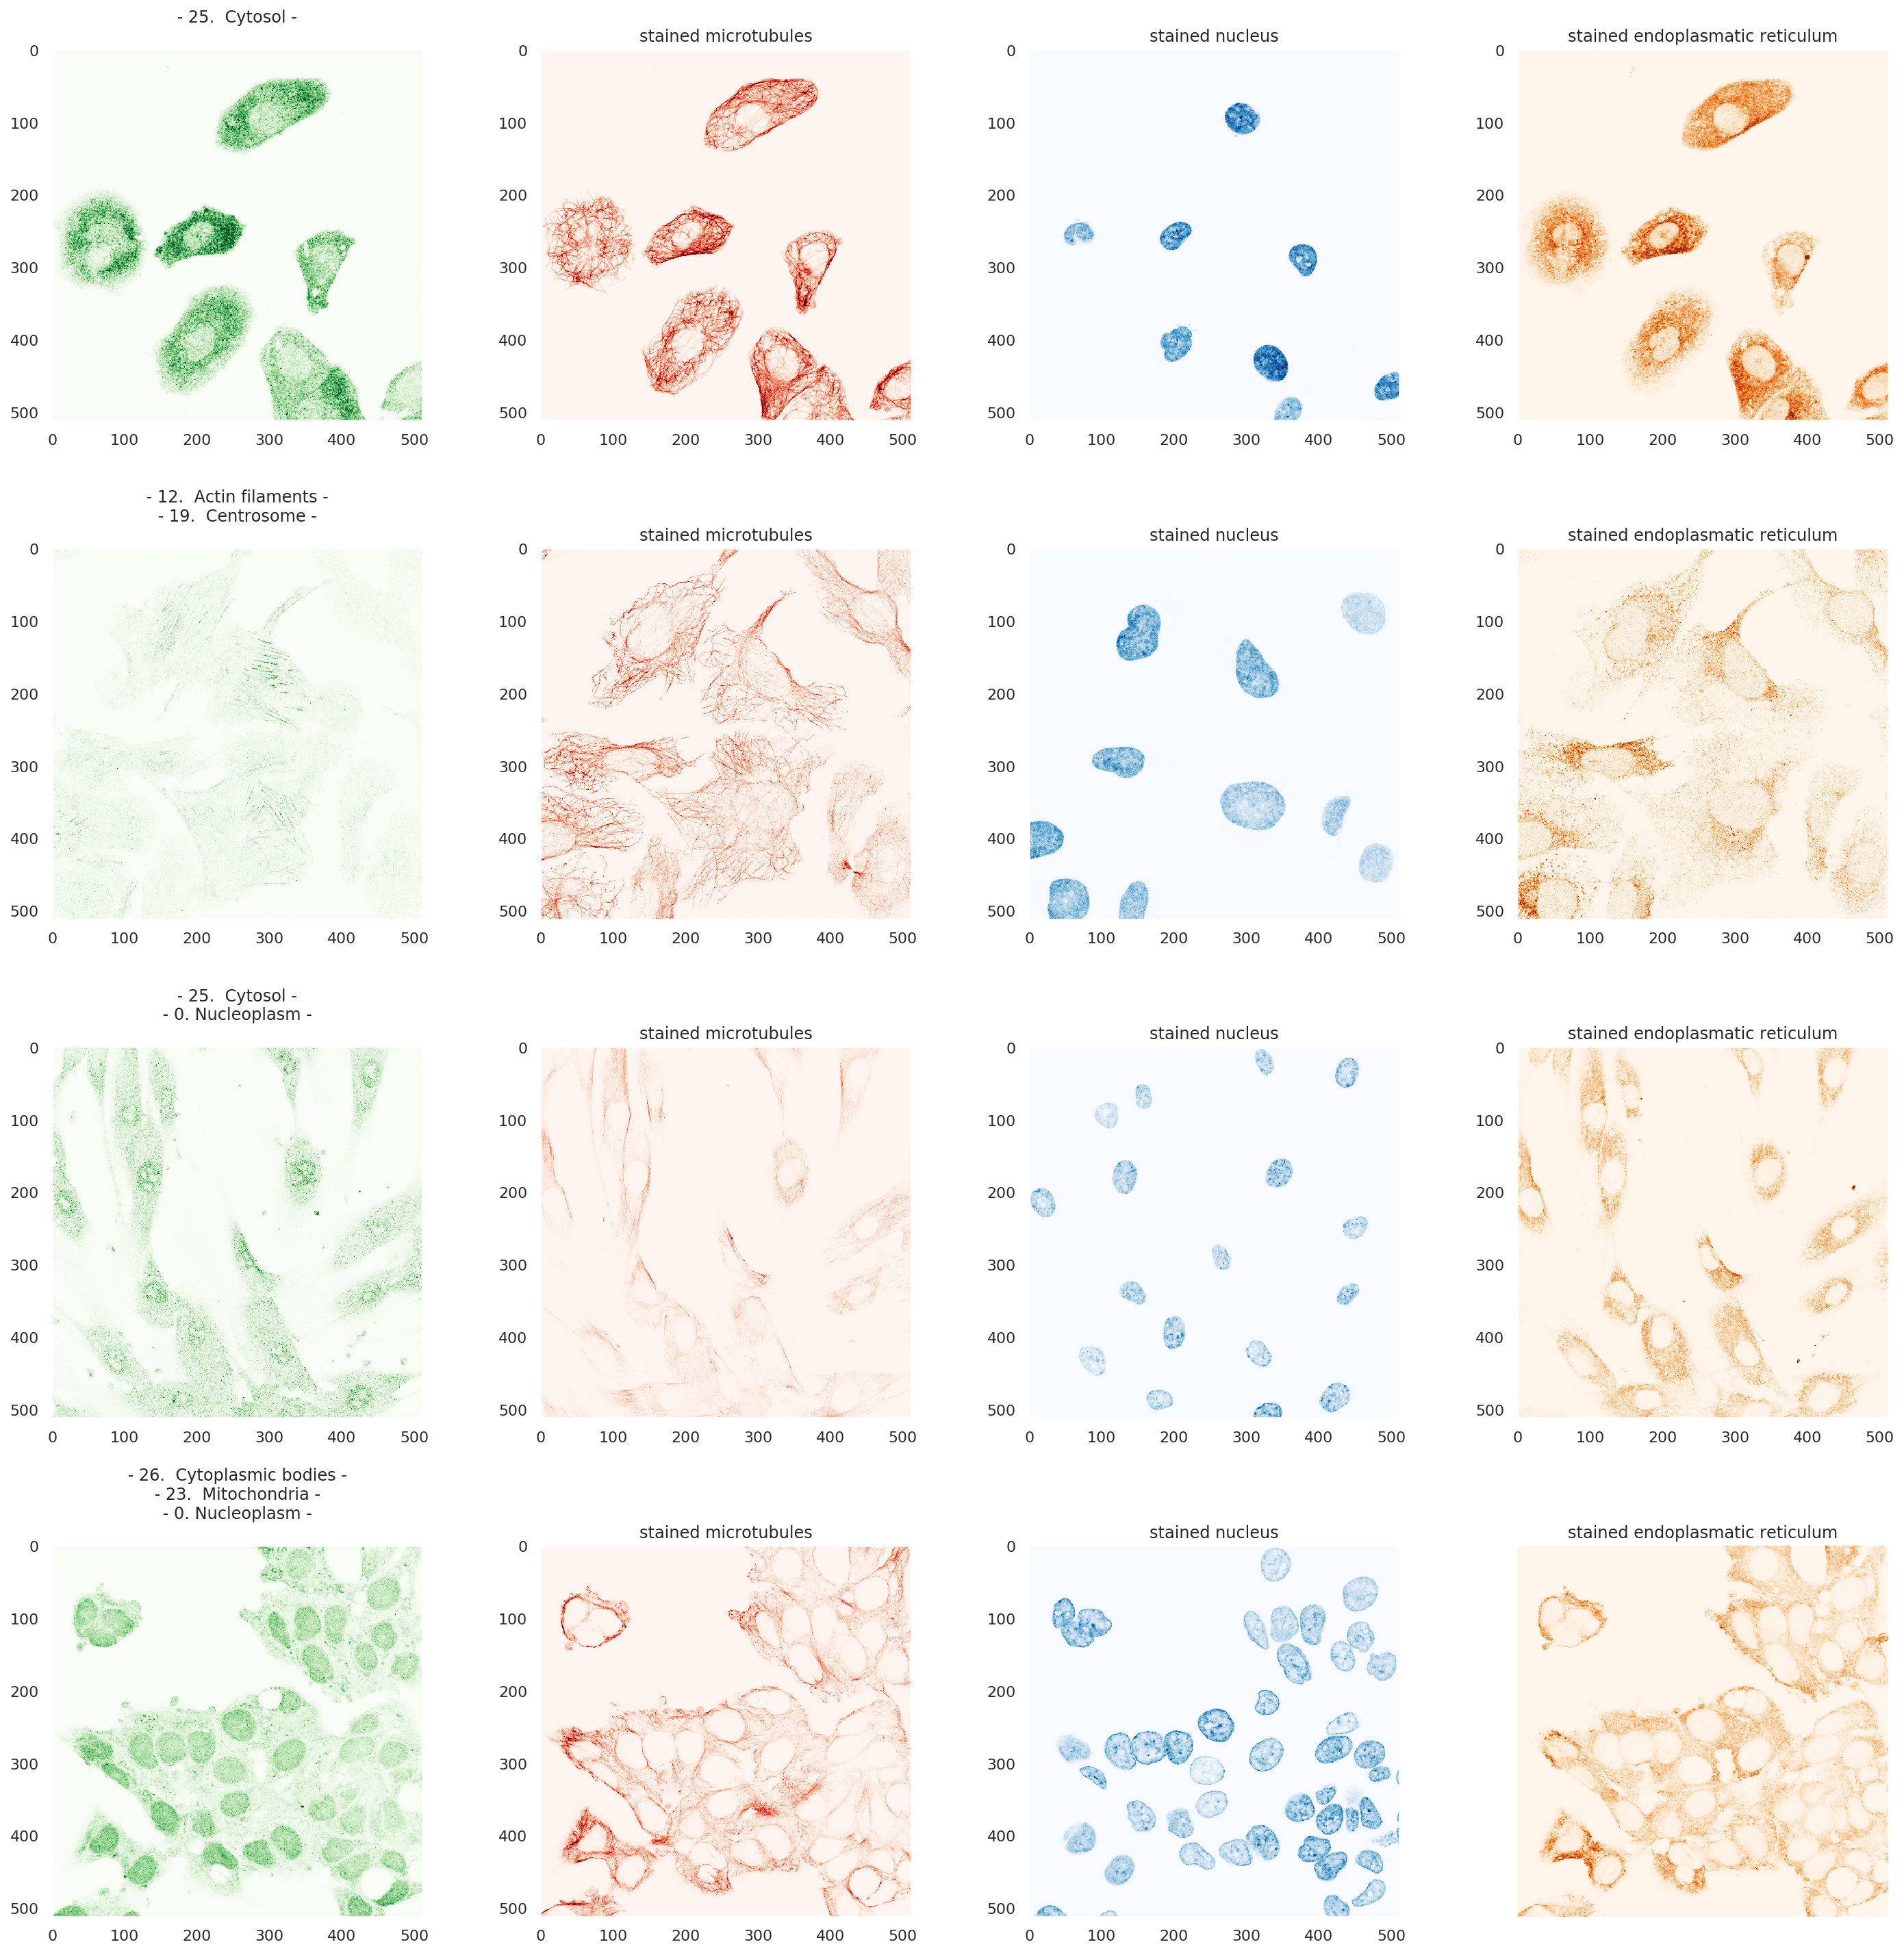

In [9]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4, 512, 512))
    images[0,:,:] = imread(basepath / (image_id + "_green" + ".png"))
    images[1,:,:] = imread(basepath / (image_id + "_red" + ".png"))
    images[2,:,:] = imread(basepath / (image_id + "_blue" + ".png"))
    images[3,:,:] = imread(basepath / (image_id + "_yellow" + ".png"))
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[0].set_title(title)
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    for ax_ind in range(len(subax)):
        subax[ax_ind].grid(False)
    return subax

def make_title(file_id):
    file_targets = train_df.loc[train_df.Id == file_id, "Target"].values[0]
    title = ""
    for t in file_targets.split():
        title += " - " + labels_dict[int(t)] + " - \n"
    return title


file_ids = [train_df.iloc[random.randint(0, len(train_df))]["Id"] for _ in range(4)]
images = [load_image(train_input_dir, file_id) for file_id in file_ids]
fig, ax = plt.subplots(len(file_ids),4,figsize=(20, 5 * len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
    
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))
    
plt.axis('off')
plt.tight_layout()

## Train/Test difference

In [10]:
train_files = os.listdir(train_input_dir)
test_files = os.listdir(test_input_dir)
percentage = np.round(len(test_files) / len(train_files) * 100)

print("The test set size turns out to be {} % of the size of the train set.".format(percentage))

The test set size turns out to be 38.0 % of the size of the train set.
